# AI-LAB EXAM 2019

### Delivery instructions
Send an email with this notebook attached where:
* Recipient: alessandro.farinelli@univr.it
* Carbon copy (CC): riccardo.sartea@univr.it
* Subjet: AI Exam 2019 - Matricola, Name Surname
* Body: Matricola, Name Surname
* Attachment: this notebook **renamed as MATRICOLA.ipynb**. To rename the notebook click on the top-left of the browser tab (on "Exam2019") and insert the new name

Every cell must run without errors when executing the notebook from top to bottom. If this is not the case, your exam may be invalidated. **Do not forget to answer the question in each assignment!**. Also, **do not forget to save the notebook! (CTRL+S)**

## Windy Gridworld environment

The environment to use for this exam is **WindyGridworld** (taken from the book of Sutton and Barto)
![WindyGridworld](images/WindyGridworld.png)

The agent starts in cell $(3, 0)$ and has to reach the goal in $(3, 7)$. All cells are safe but there is a crosswind running upward through the middle of the grid. The available actions are:
* *U*: 0
* *R*: 1
* *D*: 2
* *L*: 3

but in the middle region the resultant next states are shifted upward by a *wind* the strength of which varies from column to column (visible at the bottom of each column in the figure). For example if the agent is in position $(3, 8)$, then action *Left* would move it to position $(2, 7)$. Going *Down* from position $(1, 6)$ would move the agent to position $(0, 6)$ instead.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym
import envs
import numpy as np
import utils.heuristics as heu
from utils.fringe import FringeNode, PriorityFringe, QueueFringe
from utils.funcs import plot, build_path
from timeit import default_timer as timer

# Assignment 1

Assuming the agent has full knowledge of the environment, find the optimal path from the agent starting position to the goal with an uninformed or informed search algorithm of your choice. Suppose a step cost of 1 for any action. You have to show the result as a tuple $(path, stats)$ in the following form:
* *path* - tuple of state identifiers forming a path from the start state to the goal state. ``None`` if no solution is found
* *stats* - tuple of:
     * *time* - time elapsed between the start and the end of the algorithm
     * *expc* - number of nodes explored. A node is considered as explored when it is analyzed (state goal check, expansion, etc.)
     * *maxnodes* - maximum number of nodes in memory at the same time
     
Insert the function/s defining your algorithm of choice in the next cell

In [12]:
### INSERT YOUR ALGORITHM HERE ###
#                          _       
#                         | |      
#   __ _ _ __ ___  ___  __| |_   _ 
#  / _` | '__/ _ \/ _ \/ _` | | | |
# | (_| | | |  __/  __/ (_| | |_| |
#  \__, |_|  \___|\___|\__,_|\__, |
#   __/ |                     __/ |
#  |___/                     |___/ 
def greedy_graph_search(environment):
    """
    Greedy-best-first Graph search
    
    Args:
        environment: OpenAI Gym environment
        
    Returns:
        (path, stats): solution as a path and stats.
        The stats are a tuple of (expc, maxnodes): number of explored nodes, max nodes in memory
        
    """
    closed = set()
    fringe = PriorityFringe()
    explored_nodes = 0
    max_nodes_mem = 0
    
    start_pos = environment.state_to_pos(environment.startstate)
    goal_pos = environment.state_to_pos(environment.goalstate)
    heuristic = heu.l1_norm(start_pos, goal_pos) #<------------------- uso l1_norm
    
    fringe.add(FringeNode(environment.startstate, value=heuristic))
    while True:
        if fringe.is_empty():
            break
        node = fringe.remove()  # Retrieve node from the fringe
        explored_nodes += 1
        if(node.state in closed):
            continue
        closed.add(node.state)
        if node.state == environment.goalstate:  # Goal state check
            return build_path(node), (explored_nodes, max_nodes_mem)
        for action in range(environment.action_space.n):  # Look around
            childState = environment.sample(node.state, action)            
            child_pos = environment.state_to_pos(childState) # Posizione in coordinate ?!
            heuristic = heu.l1_norm(child_pos, goal_pos)
            
            child = FringeNode(childState, node, value=heuristic)
            fringe.add(child)
        if len(fringe) + len(closed) > max_nodes_mem:
            max_nodes_mem = len(fringe) + len(closed)
        
    return None, (explored_nodes, max_nodes_mem)

def greedy(environment, search_type):
    """
    Greedy-best-first search
    
    Args:
        environment: OpenAI Gym environment
        search_type: type of search - greedy_tree_search or greedy_graph_search (function pointer)
        
    Returns:
        (path, stats): solution as a path and stats.
        The stats are a tuple of (time, expc, maxnodes): elapsed time, number of explored nodes, max nodes in memory
    """
    t = timer()
    path, stats = search_type(environment)
    return path, (timer() - t, stats[0], stats[1])

#             _    
#     /\   /\| |/\ 
#    /  \  \ ` ' / 
#   / /\ \|_     _|
#  / ____ \/ , . \ 
# /_/    \_\/|_|\/ 
def astar_graph_search(environment):
    """
    A* Graph search
    
    Args:
        environment: OpenAI Gym environment
        
    Returns:
        (path, stats): solution as a path and stats.
        The stats are a tuple of (expc, maxnodes): number of explored nodes, max nodes in memory
    """
    closed = set()
    fringe = PriorityFringe()
    explored_nodes = 0
    max_nodes_mem = 0
    
    start_pos = environment.state_to_pos(environment.startstate)
    goal_pos = environment.state_to_pos(environment.goalstate)
    heuristic = heu.l1_norm(start_pos, goal_pos)
    
    fringe.add(FringeNode(environment.startstate, pathcost=0, value=heuristic))
    while True:
        if fringe.is_empty():
            break
        node = fringe.remove()  # Retrieve node from the fringe
        explored_nodes += 1
        if(node.state in closed):
            continue
        closed.add(node.state)
        if node.state == environment.goalstate:  # Goal state check
            return build_path(node), (explored_nodes, max_nodes_mem)
        for action in range(environment.action_space.n):  # Look around
            childState = environment.sample(node.state, action)            
            child_pos = environment.state_to_pos(childState)
            heuristic = heu.l1_norm(child_pos, goal_pos)

            child = FringeNode(childState, node, pathcost= node.pathcost + 1, value=heuristic + node.pathcost + 1)
            fringe.add(child)
        if len(fringe) + len(closed) > max_nodes_mem:
            max_nodes_mem = len(fringe) + len(closed)
    
    return None, (explored_nodes, max_nodes_mem)

def astar(environment, search_type):
    """
    A* search
    
    Args:
        environment: OpenAI Gym environment
        search_type: type of search - astar_tree_search or astar_graph_search (function pointer)
        
    Returns:
        (path, stats): solution as a path and stats.
        The stats are a tuple of (time, expc, maxnodes): elapsed time, number of explored nodes, max nodes in memory
    """
    t = timer()
    path, stats = search_type(environment)
    return path, (timer() - t, stats[0], stats[1])

Insert the code to execute your algorithm and to show the result in the next cell

In [15]:
envname = "WindyGridworld-v0"

# Create and render the environment
env = gym.make(envname)
env.render()

### CALL YOUR ALGORITHM AND SHOW RESULTS + STATS ###
#             _    
#     /\   /\| |/\ 
#    /  \  \ ` ' / 
#   / /\ \|_     _|
#  / ____ \/ , . \ 
# /_/    \_\/|_|\/ 
print("----------------> A* - Graph search version")
solution, stats = astar(env, astar_graph_search)  # Perform A* search
if solution is not None:
    solution = [env.state_to_pos(s) for s in solution]
    
# Print stats and path
print("\n\nExecution time: {0}s\nN° of nodes explored: {1}\nMax n° of nodes in memory: {2}\nSolution: {3}".format(
        round(stats[0], 4), stats[1], stats[2], solution))

#                          _       
#                         | |      
#   __ _ _ __ ___  ___  __| |_   _ 
#  / _` | '__/ _ \/ _ \/ _` | | | |
# | (_| | | |  __/  __/ (_| | |_| |
#  \__, |_|  \___|\___|\__,_|\__, |
#   __/ |                     __/ |
#  |___/                     |___/ 
print("\n\n----------------> GREEDY - Graph search version")
solution, stats = greedy(env, greedy_graph_search)  # Perform Greedy-best-first search
if solution is not None:
    solution = [env.state_to_pos(s) for s in solution]
    
# Print stats and path
print("\n\nExecution time: {0}s\nN° of nodes explored: {1}\nMax n° of nodes in memory: {2}\nSolution: {3}".format(
        round(stats[0], 4), stats[1], stats[2], solution))

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

----------------> A* - Graph search version


Execution time: 0.0267s
N° of nodes explored: 210
Max n° of nodes in memory: 86
Solution: [(3, 1), (3, 2), (3, 3), (2, 4), (1, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (4, 8), (3, 7)]


----------------> GREEDY - Graph search version


Execution time: 0.007s
N° of nodes explored: 42
Max n° of nodes in memory: 65
Solution: [(3, 1), (3, 2), (3, 3), (2, 4), (1, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (4, 8), (3, 7)]


## Question

Motivate your choice for the algorithm used. Focus only on optimality guarantees and stats (do not worry about exact numbers for the stats, just the trend). Consider both *tree search* and *graph search* variants in your motivation

## Answer

Uso l'approccio informato poichè intuitivamente usare l'euristica per dirigermi verso il goal può risultare utile, inoltre noto che non esiste un path che permette di arrivare al goal da "davanti" a causa del vento e dunque la soluzione che mi ritorna sia A* che greedy è quella migliore: tale soluzione passa da dietro al tesoro.
Inoltre posso dire che essendoci un solo percorso possibile è meglio greedy perchè esplora meno nodi di A*.

# Assignment 2

Consider the **WindyGridworld** environment defined above. Assume the reward is:

* <span style="color:red">-1</span> for every step

and the episode ends only when the goal state is reached. The action dynamics are deterministic, but the agent has no prior knowledge of the environment (there is no $T$ or $R$ function avaible for use unless the agent creates them online). It is possible however to sample the next state given the current state and an action with *sample(state, action)* (again, with a deterministic result).

Find the policies for the **WindyGridworld** environment by using *Q-Learning* ($\epsilon$-greedy) and *SARSA* ($\epsilon$-greedy) reinforcement learning algorithms. The solution returned must be a tuple *(policy, episodes)* where:
* *policy*: array of action identifiers where the $i$-th action refers to the $i$-th state
* *episodes*: array of cumulative episodes where the $i$-th value refers to cumulative number of episodes **completed** up to the $i$-th step. Example: if you execute a total number of 10 steps and your agent completes an episode after 4 steps and another one after 9, the $episodes$ array will look like this: $[0, 0, 0, 1, 1, 1, 1, 1, 2, 2]$. This means that the first episodes length is $4$ whether the second episode length is $5$.

The code used to call your algorithms is already inserted below, therefore, **pay attention to the interface (input/output) of the functions to implement!!!** In particular, **the agent is given a total number of steps to do, not a total number of episodes!!!**. Hence, if the parameter *steps* is $100$, the agent must stop after $100$ steps, regardless of how many episodes have been completed.

Insert the $\epsilon$-greedy function in the next cell

In [16]:
def epsilon_greedy(q, state, epsilon):
    """
    Epsilon-greedy action selection function
    
    Args:
        q: q table
        state: agent's current state
        epsilon: epsilon parameter
    
    Returns:
        action id
    """
    n_actions = len(q[0])
    x = np.random.choice(2, p=[1-epsilon, epsilon])
    if x == 0:
        return np.argmax(q[state])
    return np.random.randint(0, n_actions)

#print(epsilon_greedy([[1,2,3,3],[4,5,6,6],[7,8,9,9],[7,8,9,9]], 2, 1)) #test

Insert your *Q-Learning* algorithm implementation in the following cell

In [55]:
def q_learning(env, steps, alpha, gamma, epsilon):
    """
    Performs the Q-Learning algorithm for a specific environment
    
    Args:
        environment: OpenAI Gym env
        episodes: number of episodes for training
        alpha: alpha parameter
        gamma: gamma parameter
        epsilon: exploration paramenter for epsilon-greedy
    
    Returns:
        (policy, episodes): final policy, cumulative number of episodes completed at each step [array]
    """
    
    # rewards, lengths ← [0, ..., 0] . Null vectors of length episodes
    rewards = []  # Rewards list
    lengths = []  # Lengths list
    completed_episodes = [] # <--- !!!!!!!!!!!!! aggiunta rispetto l'algoritmo orginario
    
    q = np.zeros((env.observation_space.n, env.action_space.n)) # ∀a ∈ A, ∀s ∈ S initialize Q(s, a) arbitrarily
    
    ep = 0
    n_episodes = 0
    steps_count = 0 # <--- !!!!!!!!!!!!! aggiunta rispetto l'algoritmo orginario
    s = env.reset()
    for i in range(steps): # <--- !!!!!!!!!!!!! aggiunta rispetto l'algoritmo orginario
        ep += 1  # <--- !!!!!!!!!!!!! aggiunta rispetto l'algoritmo orginario
        length = 0
        reward = 0
        a = epsilon_greedy(q, s, epsilon) # a ← epsilon_greedy(Q, s, epsilon)
        s1, r, done, _ = env.step(a) # s1, r ← take_action a from state s . Act and observe
        q[s][a] = q[s][a] + alpha * (r + gamma * np.max(q[s1]) - q[s][a]) # Q(s, a) ← Q(s, a) + α(R + γ max_∈As Q(s1, a) − Q(s, a)) . TD
        s = s1 # s ← s1
        length += 1
        reward += r
        steps_count += 1  # !!!!!!!!!!!!! <--- aggiunta rispetto l'algoritmo orginario
        if done: # while (s is terminal)
            n_episodes += 1
            s = env.reset()
        completed_episodes.append(n_episodes) # <--- !!!!!!!!!!!!! aggiunta rispetto l'algoritmo orginario
        # Update rewards, lengths
        lengths.append(length)
        rewards.append(reward)
    
    policy = np.random.choice(env.action_space.n, env.observation_space.n) # Random policy (# π ← [0, ..., 0] . Null vector of length |S|)
    
    for s in range(env.observation_space.n): # for each s in S do . Extract policy
        policy[s] = np.argmax(q[s]) # π[s] ← argmax_a∈As Q(s, a)
    
    return policy, completed_episodes

Insert your *SARSA* algorithm implementation in the next cell

In [59]:
def sarsa(env, steps, alpha, gamma, epsilon):
    """
    Performs the Q-Learning algorithm for a specific environment
    
    Args:
        environment: OpenAI Gym env
        episodes: number of episodes for training
        alpha: alpha parameter
        gamma: gamma parameter
        epsilon: exploration paramenter for epsilon-greedy
    
    Returns:
        (policy, episodes): final policy, cumulative number of episodes completed at each step [array]
    """
    
    # rewards, lengths ← [0, ..., 0] . Null vectors of length episodes
    rewards = []  # Rewards list
    lengths = []  # Lengths list
    completed_episodes = [] # <--- !!!!!!!!!!!!! aggiunta rispetto l'algoritmo orginario
    
    q = np.zeros((env.observation_space.n, env.action_space.n)) # ∀a ∈ A, ∀s ∈ S initialize Q(s, a) arbitrarily
    
    ep = 0
    n_episodes = 0
    steps_count = 0 # <--- !!!!!!!!!!!!! aggiunta rispetto l'algoritmo orginario
    s = env.reset()
    for i in range(steps): # <--- !!!!!!!!!!!!! aggiunta rispetto l'algoritmo orginario
        ep += 1  # <--- !!!!!!!!!!!!! aggiunta rispetto l'algoritmo orginario
        length = 0
        reward = 0
        a = epsilon_greedy(q, s, epsilon) # a ← epsilon_greedy(Q, s, epsilon)
        s1, r, done, _ = env.step(a) # s1, r ← take_action a from state s . Act and observe
        a1 = epsilon_greedy(q, s1, epsilon) # a1 ← expl_func(Q, s1, expl_param)
        q[s][a] = q[s][a] + alpha * (r + gamma * q[s1][a1] - q[s][a]) # Q(s, a) ← Q(s, a) + α(R + γ Q(s1, a1) − Q(s, a)) . TD
        s = s1 # s ← s1
        a = a1 # a ← a1
        length += 1
        reward += r
        steps_count += 1  # !!!!!!!!!!!!! <--- aggiunta rispetto l'algoritmo orginario
        if done: # while (s is terminal)
            n_episodes += 1
            s = env.reset()
        completed_episodes.append(n_episodes) # <--- !!!!!!!!!!!!! aggiunta rispetto l'algoritmo orginario
        # Update rewards, lengths
        lengths.append(length)
        rewards.append(reward)
    
    policy = np.random.choice(env.action_space.n, env.observation_space.n) # Random policy (# π ← [0, ..., 0] . Null vector of length |S|)
    
    for s in range(env.observation_space.n): # for each s in S do . Extract policy
        policy[s] = np.argmax(q[s]) # π[s] ← argmax_a∈As Q(s, a)
    
    return policy, completed_episodes

The following code executes your two algorithms and plots a chart with the behavior of the agent in time


----------------------------------------------------------------
	Environment:  WindyGridworld-v0
----------------------------------------------------------------

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o


Q-Learning
Execution time: 0.5855s
Policy:
[['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['U' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'L' 'R' 'D']
 ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'U' 'R' 'D']
 ['R' 'R' 'R' 'R' 'R' 'D' 'U' 'D' 'L' 'L']
 ['D' 'R' 'D' 'D' 'U' 'U' 'U' 'D' 'L' 'D']
 ['R' 'R' 'R' 'R' 'U' 'U' 'U' 'U' 'L' 'L']]

SARSA
Execution time: 1.3561s
Policy:
[['U' 'D' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
 ['R' 'R' 'R' 'U' 'R' 'R' 'R' 'R' 'R' 'D']
 ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'L' 'R' 'D']
 ['R' 'R' 'U' 'R' 'R' 'R' 'R' 'U' 'U' 'D']
 ['R' 'R' 'R' 'R' 'R' 'D' 'U' 'D' 'L' 'L']
 ['R' 'R' 'D' 'R' 'U' 'U' 'U' '

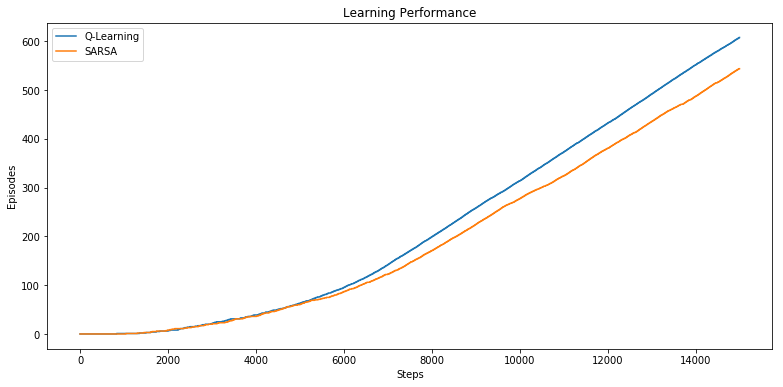

In [60]:
envname = "WindyGridworld-v0"

print("\n----------------------------------------------------------------")
print("\tEnvironment: ", envname)
print("----------------------------------------------------------------\n")

env = gym.make(envname)
env.render()
print()

# Learning parameters
steps = 15000
alpha = .5
gamma = .9
delta = 1e-3
epsilon = .1

t = timer()

# Q-Learning epsilon greedy
policy, episodes = q_learning(env, steps, alpha, gamma, epsilon)
print("Q-Learning\nExecution time: {0}s\nPolicy:\n{1}\n".format(round(timer() - t, 4), np.vectorize(env.actions.get)(policy.reshape(
    env.shape))))
q_learning_series = {"x": np.arange(steps), "y": episodes, "label": "Q-Learning"}

# SARSA epsilon greedy
policy, episodes = sarsa(env, steps, alpha, gamma, epsilon)
print("SARSA\nExecution time: {0}s\nPolicy:\n{1}\n".format(round(timer() - t, 4), np.vectorize(env.actions.get)(policy.reshape(
    env.shape))))
sarsa_series = {"x": np.arange(steps), "y": episodes, "label": "SARSA"}
plot([q_learning_series, sarsa_series], "Learning Performance", "Steps", "Episodes")

## Question

Explain the differences in the learning performance between the two algorithms by explicitly referring to the chart above

## Answer

q_learning è OFF policy ciò vuol dire che non guarda la policy e cercherà di arrivare in fondo con
il reward migliore (e dunque arrivare in fondo prima possibile nonostante il rischio ) NB!! questa cosa solo durante il training.
La soluzione di SARSA esplora meno rispetto a q_learning poichè è on policy (esploro in base alla policy che all'inizio non è ottima).